## MLS PRoject 2020 

### Slawomir Sowa
### G00375619@gmit.ie
---

### Subject:
In this project you must create a web service that uses machine learning to make predictions based on the data set powerproduction available on Moodle. The goal is to
produce a model that accurately predicts wind turbine power output from wind speed
values, as in the data set. You must then develop a web service that will respond with
predicted power values based on speed values sent as HTTP requests. Your submission
must be in the form of a git repository containing, at a minimum, the following items:
1. Jupyter notebook that trains a model using the data set. In the notebook you
should explain your model and give an analysis of its accuracy.
2. Python script that runs a web service based on the model, as above.
3. Dockerfile to build and run the web service in a container.
4. Standard items in a git repository such as a README.

###  Wind Power Research

#### FUndmatental Equation of Wind Power
Wind Power depends on:
* amount of air (volume)
* speed of air (velocity)
* mass of air (density)

and the Wind Power can be calculated from 

$$P = \frac{1}{2} \rho Av^3  $$

Where: $\rho$ - density of the air, $A$ capture area of the wind, $v$ wind speed <em>[1]</em>

The most important variable is windspeed. The area swept out by of the turbine is a constant and the density of air is generally taken as $1.225 kg/m^3$, its vale at sea level at 15 degrees $C$. <em>[2]</em>

The swept area can be calculated as:
$$ A = \pi r^2$$

![Swept Area](img/swept_area.png)

A German physicist Albert Betz concluded in 1919 that no wind turbine can convert more than 16/27 (59.3%) of the kinetic energy of the wind into mechanical energy turning a rotor. To this day, this is known as the Betz Limit or Betz' Law. The theoretical maximum power efficiency of any design of wind turbine is 0.59 (i.e. no more than 59% of the energy carried by the wind can
be extracted by a wind turbine). This is called the “power coefficient” and is defined as:

$$ C_{p_{max}} = 0.59$$

Also, wind turbines cannot operate at this maximum limit. The Cp value is unique to each turbine type and is a function of wind speed that the turbine is operating in. Once we incorporate various engineering requirements of a wind turbine - strength and durability in particular - the real world limit is well below the Betz Limit with values of 0.35-0.45 common even in the best designed wind turbines. <em>[1]</em>

$$ P_{avail} = \frac{1}{2} \rho Av^3 C_p $$

#### Turbine Output vs Winds Speed

The curve shows that the turbine starts generateingg power at around 3 $m/s$ - the cut-in speed. Slower wind don't have enough power to make the rotor spin. As wind speed increases, there's a rapid increace in power. The sut_down speed is the speed at wi
hich the turbine will apply a braking mechanism to prevent damage. <em>[3]</em>

![chart](img/turbine_chart.png)


<em>[1].</em> Wind Turbine Power Calculations;  https://www.raeng.org.uk/publications/other/23-wind-turbine <br>
<em>[2].</em> The Missing Link Between Air Density And Wind Power Production; https://www.technologyreview.com/2011/03/15/196333/the-missing-link-between-air-density-and-wind-power-production/<br>
<em>[3]</em> Rooftop Wind Turbines: Are They Worthwhile? https://www.engineering.com/ElectronicsDesign/ElectronicsDesignArticles/ArticleID/9556/Rooftop-Wind-Turbines-Are-They-Worthwhile.aspx

### Importing Libraries

In [70]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

### Load Data Set

In [66]:
# using pandas read_csv method to read data from file
df = pd.read_csv("powerproduction.csv")
df.head(15)


,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


In [64]:
df.tail(15)

,speed,power
485,24.249,103.700
486,24.299,93.694
487,24.349,93.078
488,24.374,98.223
489,24.399,95.117
490,24.499,0.000
491,24.525,0.000
492,24.575,0.000
493,24.650,0.000
494,24.750,0.000


Text(0.5, 0, 'Wind Speed')

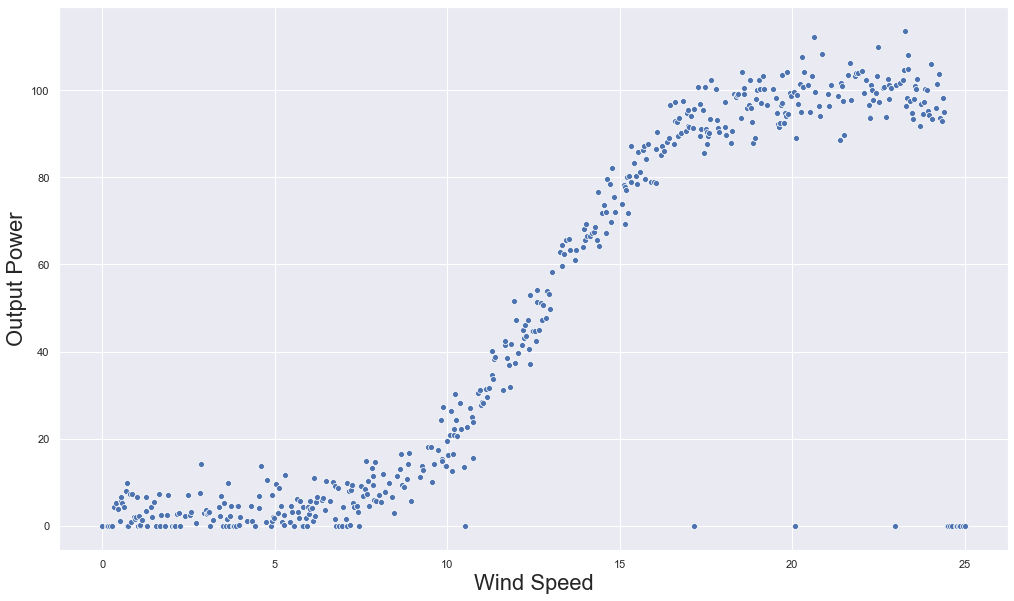

In [79]:
# https://stackoverflow.com/a/47955814
plt.figure(figsize=(17,10))
ax = sns.scatterplot(data=df, x="speed", y="power" )
ax.set_ylabel('Output Power', fontsize=22)
ax.set_xlabel('Wind Speed', fontsize=22)

### Cleaning data - remove outliers 
To remove outliers I will use Z-Score method. 
The intuition behind Z-score is to describe any data point by finding their relationship with the Standard Deviation and Mean of the group of data points. Z-score is finding the distribution of data where mean is 0 and standard deviation is 1 i.e. normal distribution.<em>[4]</em>


In [72]:
z = np.abs(stats.zscore(df))
print(z)

[[1.74436299e+00 1.15494809e+00]
 [1.72704460e+00 1.15494809e+00]
 [1.72358092e+00 1.15494809e+00]
 [1.71318989e+00 1.15494809e+00]
 [1.70626254e+00 1.15494809e+00]
 [1.69933518e+00 1.05076974e+00]
 [1.68894415e+00 1.03020347e+00]
 [1.68201680e+00 1.06291706e+00]
 [1.67495090e+00 1.12973938e+00]
 [1.67148722e+00 1.02137562e+00]
 [1.66802354e+00 9.98644481e-01]
 [1.66455986e+00 1.02888050e+00]
 [1.65763251e+00 1.05343974e+00]
 [1.65070515e+00 9.63140615e-01]
 [1.64724148e+00 9.20516732e-01]
 [1.64377780e+00 1.15494809e+00]
 [1.64031412e+00 1.15494809e+00]
 [1.63338677e+00 9.80050654e-01]
 [1.62992309e+00 1.13582507e+00]
 [1.62645941e+00 9.78150380e-01]
 [1.61606838e+00 1.10693608e+00]
 [1.61260471e+00 1.11624503e+00]
 [1.60914103e+00 1.10530041e+00]
 [1.60567735e+00 9.98331778e-01]
 [1.60221367e+00 1.15494809e+00]
 [1.59875000e+00 1.10479527e+00]
 [1.59528632e+00 1.15494809e+00]
 [1.59182264e+00 1.15203754e+00]
 [1.58489529e+00 1.12589072e+00]
 [1.57104058e+00 1.07381358e+00]
 [1.567576

In [78]:
threshold = 3
print(np.where(z > 3))

(array([], dtype=int64), array([], dtype=int64))


### RE

<em>[1].</em> Wind Turbine Power Calculations;  https://www.raeng.org.uk/publications/other/23-wind-turbine <br>
<em>[2].</em> The Missing Link Between Air Density And Wind Power Production; https://www.technologyreview.com/2011/03/15/196333/the-missing-link-between-air-density-and-wind-power-production/<br>
<em>[3]</em> Rooftop Wind Turbines: Are They Worthwhile? https://www.engineering.com/ElectronicsDesign/ElectronicsDesignArticles/ArticleID/9556/Rooftop-Wind-Turbines-Are-They-Worthwhile.aspx<br>
<em>[4]</em> Ways to Detect and Remove the Outliers; https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba; May 22, 2018